In [35]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [66]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS=30

In [37]:
df = tf.keras.preprocessing.image_dataset_from_directory(r'C:\Users\Admin\Desktop\Data_set_play\PlantVillage',
                                                        shuffle=True,
                                                        image_size = (IMAGE_SIZE,IMAGE_SIZE),
                                                        batch_size = BATCH_SIZE)

Found 2475 files belonging to 2 classes.


In [38]:
class_name = df.class_names
class_name

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [39]:
len(df)

78

In [40]:
for batch_image, labels_batch in df.take(1):
    print(batch_image.shape) # 32 picture , 32*32 size , 3RGB
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 1 1 1]


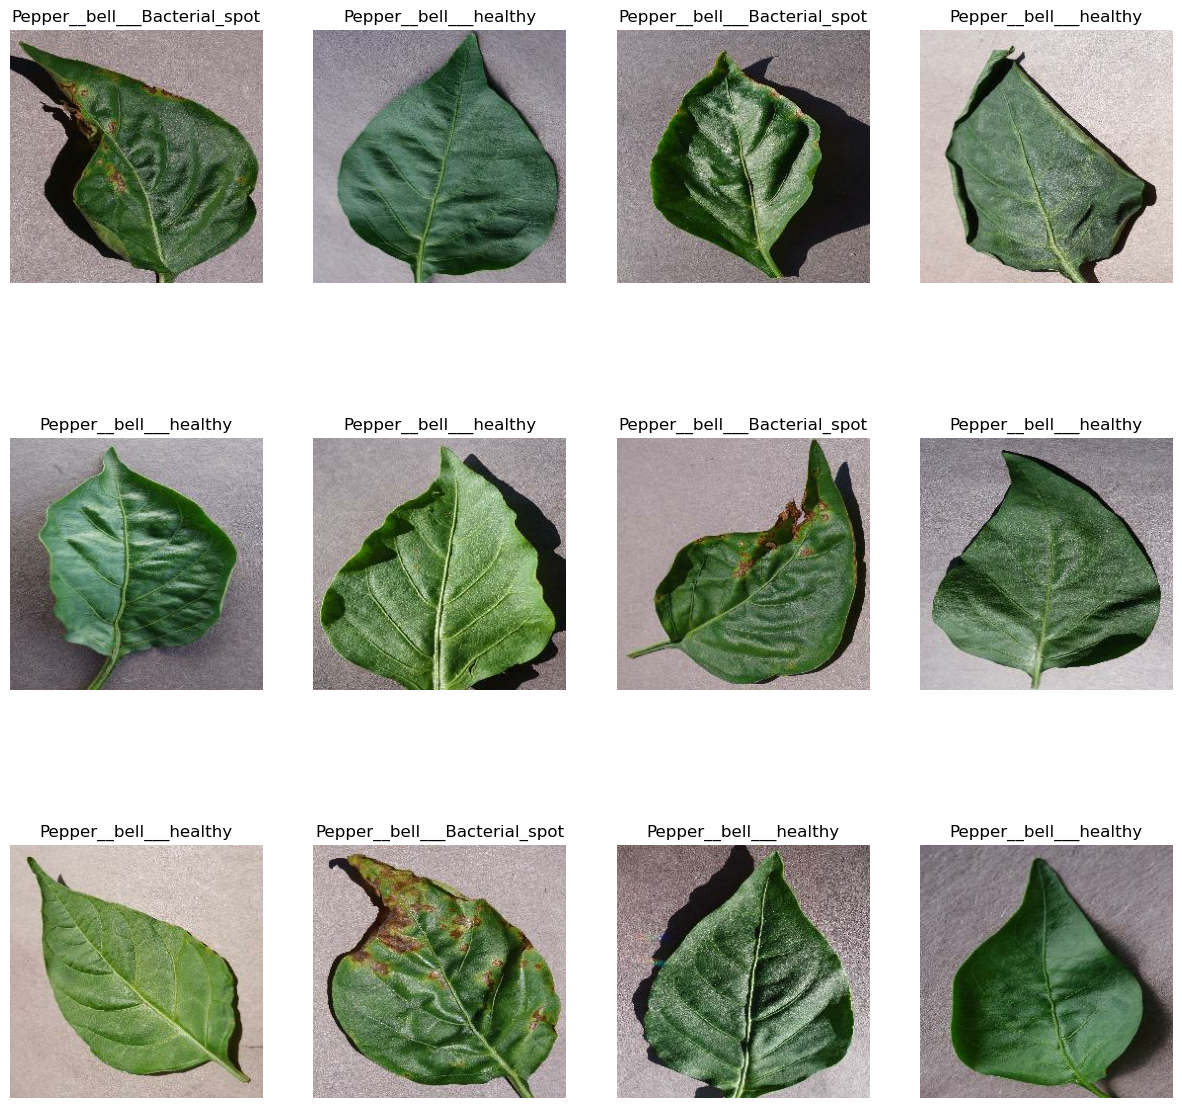

In [41]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in df.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[labels_batch[i]])
        plt.axis("off")

In [42]:
len(df)

78

In [43]:
train_size = 0.8
len(df)*train_size

62.400000000000006

In [44]:
train_ds = df.take(516)
len(train_ds)

78

In [45]:
test_ds = df.skip(516)
len(test_ds)

0

In [46]:
val_size=0.1
len(df)*val_size

7.800000000000001

In [47]:
val_ds = test_ds.take(64) # a[:64]
len(val_ds)

0

In [48]:
test_ds = test_ds.skip(64) # a[64:]
len(test_ds)

0

In [49]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    remaining_ds = ds.skip(train_size)
    val_ds = remaining_ds.take(val_size)
    test_ds = remaining_ds.skip(val_size)
    
    return train_ds, val_ds, test_ds

In [50]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(df)

In [51]:
len(train_ds)

62

In [52]:
len(val_ds)

7

In [53]:
len(test_ds)

9

In [54]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [55]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [56]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [57]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [58]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [59]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [60]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [61]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
62/62 [==============================] - 73s 1s/step - loss: 0.4885 - accuracy: 0.7743 - val_loss: 0.5069 - val_accuracy: 0.8348
Epoch 2/30
62/62 [==============================] - 68s 1s/step - loss: 0.1675 - accuracy: 0.9435 - val_loss: 0.1974 - val_accuracy: 0.9509
Epoch 3/30
62/62 [==============================] - 70s 1s/step - loss: 0.1077 - accuracy: 0.9674 - val_loss: 0.0754 - val_accuracy: 0.9777
Epoch 4/30
62/62 [==============================] - 78s 1s/step - loss: 0.0520 - accuracy: 0.9868 - val_loss: 0.0608 - val_accuracy: 0.9955
Epoch 5/30
62/62 [==============================] - 72s 1s/step - loss: 0.0447 - accuracy: 0.9868 - val_loss: 0.0409 - val_accuracy: 0.9955
Epoch 6/30
62/62 [==============================] - 72s 1s/step - loss: 0.0358 - accuracy: 0.9913 - val_loss: 0.0470 - val_accuracy: 0.9866
Epoch 7/30
62/62 [==============================] - 76s 1s/step - loss: 0.0183 - accuracy: 0.9949 - val_loss: 0.0368 - val_accuracy: 0.9955
Epoch 8/30
62/62 [==

In [62]:
scores = model.evaluate(test_ds)
scores

9/9 [==============================] - 4s 252ms/step - loss: 3.5878e-04 - accuracy: 1.0000


[0.00035878317430615425, 1.0]

In [63]:
print(history.params,history.history.keys())

{'verbose': 1, 'epochs': 30, 'steps': 62} dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [64]:
accuracy = history.history['accuracy']
validation_acc = history.history['val_accuracy']

loss = history.history['loss']
validation_loss = history.history['val_loss']

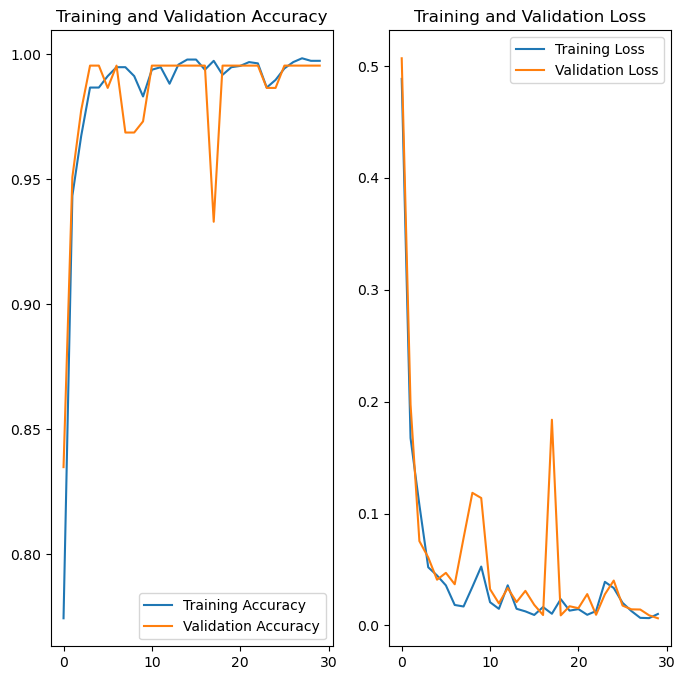

In [67]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), validation_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Pepper__bell___healthy
1/1 [==============================] - 0s 415ms/step
predicted label: Pepper__bell___healthy


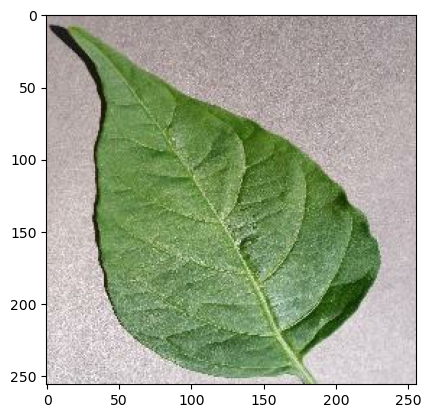

In [68]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [69]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 27ms/step


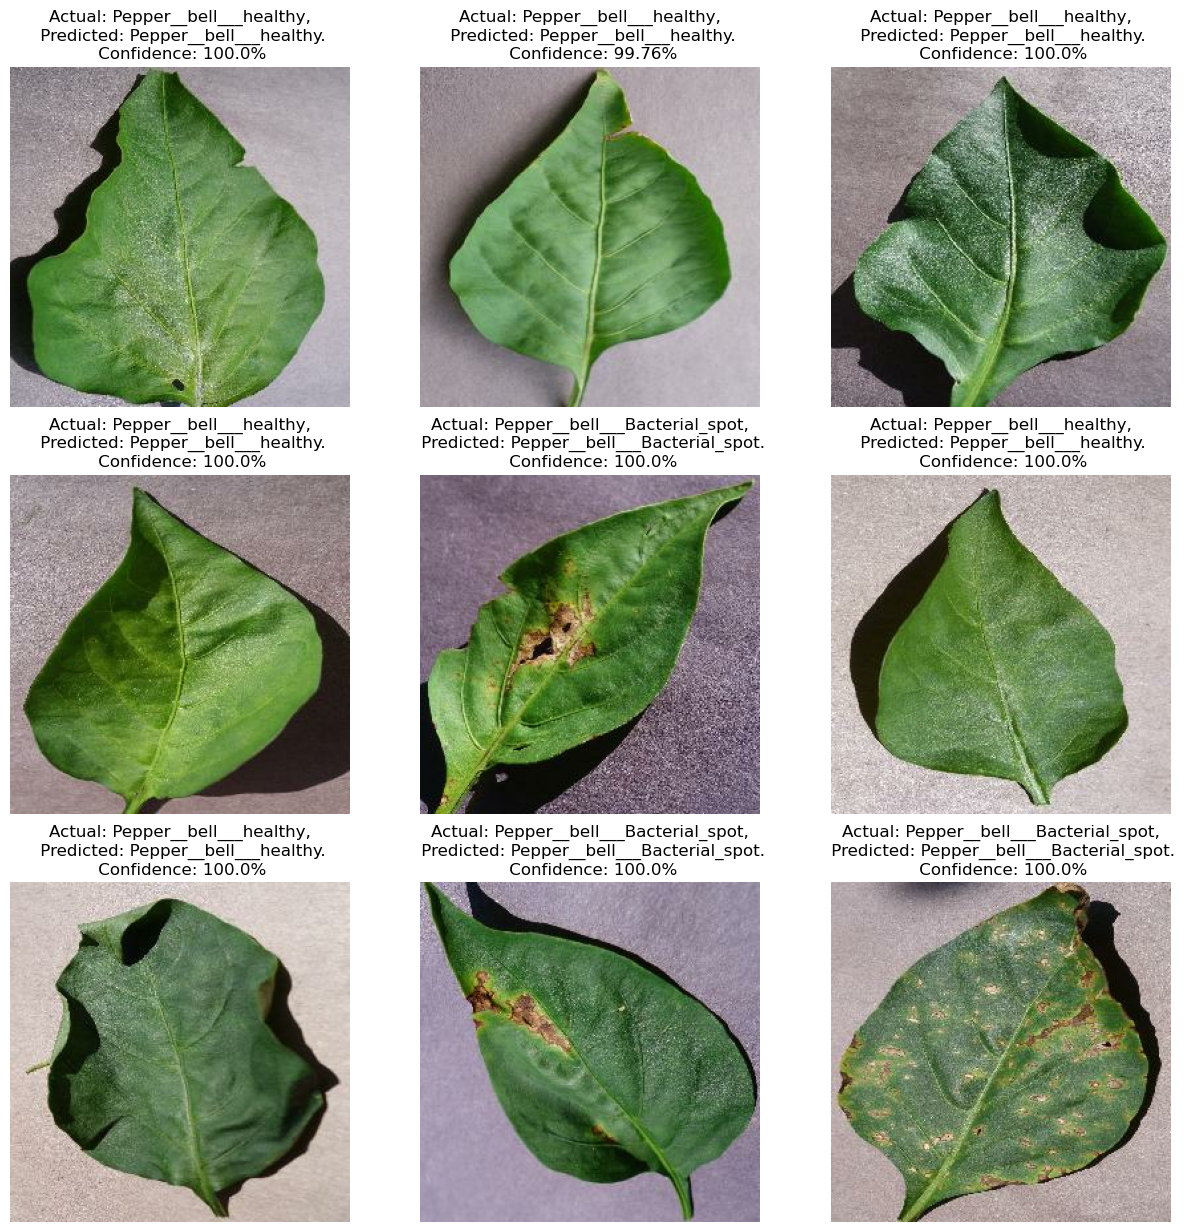

In [70]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")